



## Classifying Characters with Disabilities in Fiction from the Words Most Associated with Them: A Pilot Project
Ryan Dubnicek (May 11, 2017)

### Introduction & Project Summary
This project seeks to build a classifier in Python, using naïve Bayes, to pilot identification of characters with disabilities in fiction. I use data resulting from David Bamman and Ted Underwood’s work with HathiTrust fiction data using Bamman’s Book NLP  pipeline. I identified 54 characters from just over 30 volumes that had disabilities of some kind—for this project, disabilities are defined as both physical and mental, as well as conditions that are found in the Diagnostic and Statistical Manual of Mental Disorders, Fifth Edition (DSM-5). This is certainly not a perfect definition, but it’s one to use to ground my classifications, and one that is wide enough to not prohibit this type of study at all due to lack of training data.

In the end, I was able to us naïve Bayes to train a classifier that reliably picked out characters with disabilities amongst the ~120 characters chosen for study, with a 92% average accuracy. After completing the classifier, and without the compute resources to extend it run against characters for all  ~94,000 volumes of fiction against which Book NLP was run to extract data, I decided to take a deeper look into the words associated with each class of characters. I used TextBlob  to run sentiment analysis and objectivity of said analysis, against words for each character, and also used some homegrown functions that leverage Dunnings log likelihood to pull the most overrepresented and underrepresented words for each class of character. All together, this data affirmed some assumptions that many in disability studies would’ve made prior to this project: fewer action words were in the top words associated with characters with disabilities and average sentiment is 2.5 times lower than the words that are associated with characters without. However, objectivity of sentiment for words associated with characters with disabilities was lower, which was a surprise, given the radically different average sentiment, and the distribution of sentiment per character, with most characters sentiments below the neutral line, as compared to a normal distribution.

In [854]:
import csv, os, math, random
import pandas as pd
import numpy as np
from collections import Counter
from textblob import TextBlob
import random
import matplotlib
import seaborn
%matplotlib inline

### Preface
This notebook is a companion to a short write-up, available [here](), that makes up my final project for LID 590DSH, Data Science in the Humanities, taught by Professor Ted Underwood at the UIUC School of Information Sciences. This project uses characters and the words associated with them that were extracted from fiction in [HathiTrust (HT)](https://www.hathitrust.org). I employ a number of functions developed over the course of the class, most authored by or seeded by Dr. Underwood, and modified--to varying levels--by me. I don't purport necessarily that they are the best version of their methods, for instance, I employ a homegrown naive Bayes classifier rather than use TextBlob's or Scikit-learn's versions. However, each is understandable to me, a relative text mining novice, and shamefully, but truthfully fierce statistics novice. Naive Bayes may not be the best classifier in this instance either, but it is a classifier I understand and have experience with. Should this project ever grow from this relative pilot project, a look into which classifier might best suit my needs is a must.

If you have any questions, please feel free to drop me a note at rdubnicek@gmail.com

### Data Collection and Cleaning
As my write-up mentions, I worked off of character data that Ted Underwood and David Bamman, using Bamman's [Book NLP](https://github.com/dbamman/book-nlp), a natural language processing (NLP) pipeline that scales specifically for books and other long texts, extracted from fiction in HT. This data was extracted into json, and parsed by Dr. Underwood, using a munging python notebook. My entry into the data came after characters for my small corpus were gathered from the overall character data and sent to me in .csv form. At this point, the data looked like this:

In [850]:
# more data massaging by adding a 'bookname' column that allows me to better identify the books in question,
#  in preparation for identifying the characters with disabilities (manually)

# for i in ch_df.index:
#         bookid = ch_df['bookid'][i]
#         if bookid == '6479':
#             ch_df['bookname'][i] = 'Notre Dame de Paris'
#         elif bookid == '8469':
#             ch_df['bookname'][i] = 'Wuthering Heights'
#         elif bookid == 'mdp.39015000608102':
#             ch_df['bookname'][i] = 'Winesburg, Ohio'
#         elif bookid == 'mdp.39015002311556':
#             ch_df['bookname'][i] = 'The Secret Garden'
#         elif bookid == 'uc2.ark+=13960=t22b8w678':
#             ch_df['bookname'][i] = 'The Crux'
#         elif bookid == 'inu.30000003130071':
#             ch_df['bookname'][i] = "Lady Chatterley's Lover"
#         elif bookid == 'mdp.39015002153180':
#             ch_df['bookname'][i] = 'A Good Man is Hard to Find'
#         elif bookid == 'mdp.39015002260167':
#             ch_df['bookname'][i] = 'Of Mice and Men'
#         elif bookid == 'mdp.39015008102165':
#             ch_df['bookname'][i] = 'In This Sign'
#         elif bookid == 'mdp.39015008821251':
#             ch_df['bookname'][i] = 'The Illearth War'
#         elif bookid == 'mdp.39015043002289':
#             ch_df['bookname'][i] = 'Johnny Got His Gun'
#         elif bookid == 'pst.000022105387':
#             ch_df['bookname'][i] = 'The Wounded Land'
#         elif bookid == 'uc1.b4439246':
#             ch_df['bookname'][i] = 'The One Tree'
#         elif bookid == 'mdp.39015040597794':
#             ch_df['bookname'][i] = 'Flowers for Algernon'
#         elif bookid == 'mdp.39015062063501':
#             ch_df['bookname'][i] = 'The Curious Incident of the Dog in the Night-Time'
#         elif bookid == 'mdp.39015054102655':
#             ch_df['bookname'][i] = 'The English Patient'
#         elif bookid == 'uc1.32106011264659':
#             ch_df['bookname'][i] = 'Cathedral'
#         elif bookid == 'pst.000044192167':
#             ch_df['bookname'][i] = 'The Heart is a Lonely Hunter'
#         elif bookid == 'mdp.39015054067759':
#             ch_df['bookname'][i] = 'The Things They Carried'
#         elif bookid == 'mdp.39015046349141':
#             ch_df['bookname'][i] = 'The Sound and the Fury'
#         elif bookid == 'mdp.39015040081708':
#             ch_df['bookname'][i] = 'Geek Love'
#         elif bookid == 'pst.000018729719':
#             ch_df['bookname'][i] = 'The Bell Jar'
#         elif bookid == 'uc1.32106010927215':
#             ch_df['bookname'][i] = "One Flew over the Cuckoo's Nest"
#         elif bookid == 'uc1.b3462870':
#             ch_df['bookname'][i] = 'Alice in Bed'
#         elif bookid == 'mdp.39015028400326':
#             ch_df['bookname'][i] = 'Jewel'
#         elif bookid == 'mdp.39015063339868':
#             ch_df['bookname'][i] = 'We Are All Welcome Here'
#         elif bookid == 'uc1.32106002122734':
#             ch_df['bookname'][i] = 'To Kill A Mockingbird'
#         elif bookid == 'uc1.32106014098278':
#             ch_df['bookname'][i] = "The Optimist's Daughter"
#         elif bookid == 'uc1.$b322793':
#             ch_df['bookname'][i] = 'The Last September'
#         elif bookid == 'uc1.$b784307':
#             ch_df['bookname'][i] = 'Back'

# ch_df.head(50)

# title_list = []

# for i in ch_df.index:
#         bookname = ch_df['bookname'][i]
#         title_list.append(bookname)
# titles = set(title_list)
# for title in titles:
#     print(title)

In [851]:
# one_flew_char = ['Thomas Covenenant','Charley', 'Mr. Summers','McMurphy','William Bibbit','R.P. McMurphy','Fredrickson','Bruce','Mr. Bancini','Mr. Bromden','Williams'
#            'Mr. Bibbit','Ruckly', 'Martini','Sefelt', 'Ellis','Billy Boy','Billy','Matterson','George','']

# geek_love_list = ['Arturo','Iphy','Olympia Binewski','Fortunato','Elly','Electra','Iphigenia','Miss Olympia','Chick']

# for i in ch_df.index:
#         bookname = ch_df['bookname'][i]
#         if bookname == "The Heart is a Lonely Hunter":
#             name = ch_df['name'][i]
#             words = ch_df['words'][i]
# #             if name == 'Joe':
# #                 print(words)
#             print(name)
#             if name == 'Quasimodo':
#                 ch_df['has_disability'][i] = 1
# #             elif name == 'Antonapoulous':
# #                 ch_df['has_disability'][i] = 1
#             else:
#                 ch_df['has_disability'][i] = 0

# true_titles = set(titles)
# for line in true_titles:
#     print(line)

# ch_df_copy = ch_df



# ch_df.head(100)

In [852]:
# ch_df['has_disability'] = 0


# ch_df.head()

In [853]:
# dis_char_list = []
# no_dis_char_list = []

# for i in ch_df.index:
#     bookname = ch_df['bookname'][i]
#     dis = ch_df['has_disability'][i]
#     if dis == 1:
#         name = ch_df['name'][i]
#         dis = ch_df['has_disability'][i]
#         dis_char_list.append(name)
#         print(name)
#     elif dis != 1:
#         no_dis_char_list.append(name)
#             words = ch_df['words'][i]
#             if name == 'Joe':
#                 print(words)
#             print(name)
#             if name == 'Quasimodo':
#                 ch_df['has_disability'][i] = 1
#             elif name == 'Antonapoulous':
#                 ch_df['has_disability'][i] = 1
#             else:
#                 ch_df['has_disability'][i] = 0

# print('There are', len(dis_char_list), 'characters with disabilities in this corpus.')
# print('There are', len(no_dis_char_list), 'characters with disabilities in this corpus.')

In [ ]:
ch_df_copy = ch_df


In [ ]:
ch_df_copy.shape

(705, 5)

In [245]:
# cdata = open('test.csv', 'r')
# # print(cdata)
# ch_df_copy = pd.read_csv(cdata, encoding='utf-8')

In [246]:
dis_wrd_ct = 0
no_dis_wrd_ct = 0
no_dis_words = []
# # no_dis_row = 0
dis_words = []

for i in ch_df_copy.index:
    blob = TextBlob(ch_df_copy['words'][i])
    words = blob.words
    dis = ch_df_copy['has_disability'][i]
    if dis == 0:
        no_dis_wrd_ct += len(words)
print('this many no dis words:', no_dis_wrd_ct)


# for i in ch_df_copy.index:
#     dis = ch_df_copy['has_disability'][i]
#     if dis == 0:
#         blob = TextBlob(ch_df_copy['words'][i])
#         wrds = blob.words
#         # num = len(wrds)
#         no_dis_words.append(wrds[0:23])
#         # ch_df_copy.drop(i, inplace=True)

# # print(no_dis_words)     
        
# # print('new shape is', ch_df_copy.shape)

for i in ch_df_copy.index:
    blob = TextBlob(ch_df_copy['words'][i])
    words = blob.words
    dis = ch_df_copy['has_disability'][i]
    if dis == 1:
#         dis_words.append(words)
        dis_wrd_ct += len(words)
print('this many dis words:', dis_wrd_ct)

# # test_words = ['alls my life i had to fight', 'if somebody kill my son then somebody gettin killed', 'i remember at michaels house in the living room when you kissed my neck and i almost touched your blouse']

# num = 0

# for i in ch_df_copy.index:
#     dis = ch_df_copy['has_disability'][i]
#     words = ch_df_copy['words'][i]
#     if dis == 0 and len(words) < 40:
#         words = ch_df_copy['words'][i]
#         no_dis_words.append(words)


# for i in ch_df_copy.index:
#     dis = ch_df_copy['has_disability'][i]
#     words = ch_df_copy['words'][i]
#     if dis == 0 and len(words) < 40:
#         ch_df_copy.drop(i, inplace=True)

# ch_df_copy.shape
# no_dis_df.head()

# no_dis_words2 = []

# for i in ch_df_copy.index:
#     word_list = []
#     dis = ch_df_copy['has_disability'][i]
#     words = ch_df_copy['words'][i]
#     if dis == 0:
#         split = words.split()
#         word_list.append(split)
#         words = concat()

# f1 score--precision: scikit learn version of MNB, 
#  will give predicitons by row, then you can calculate the true negatives, true positives, precision, 
#  f1 is close to an average between precision and recall. model_selection (cross val score) can pass a parameter for f1 score object as a
#  parameter and it should use that to cross validate and return the f1.



this many no dis words: 16638
this many dis words: 14751


In [741]:
# for i in ch_df_copy.index:
#     dis = ch_df_copy['has_disability'][i]
#     words = ch_df_copy['words'][i]
#     if dis == 0 and i%5 == int:
#         ch_df_copy.drop(i, inplace=True)

# print(ch_df_copy.shape)        
# ch_df_copy.head(25)


# for i in ch_df_copy2.index:
#     dis = ch_df_copy2['has_disability'][i]
#     words = ch_df_copy2['words'][i]
#     if dis == 0 and len(words) < 150 and i%2 == 0:
#         print('found one')
#         ch_df_copy2.drop(i, inplace=True)

In [249]:
# dis_wrd_ct = 0

# for i in ch_df_copy.index:
#     blob = TextBlob(ch_df_copy['words'][i])
#     words = blob.words
#     dis = ch_df_copy['has_disability'][i]
#     if dis == 1:
#         # dis_words.append(words)
#         dis_wrd_ct += len(words)
# print('this many dis words:', dis_wrd_ct)

this many dis words: 14751


In [216]:
# ch_df_copy.to_csv('test.csv')

In [742]:
# chardat= open('/Users/rdubnic2/Desktop/LIS 590DSH Final Project/test.csv', 'r')
# char_df = pd.read_csv(chardat, encoding='utf-8')

# char_df.head()

In [743]:
# del char_df['Unnamed: 0']

# char_df.head()

In [792]:
# characters.head()

# del characters['bookid']
# del characters['bookname']
# del characters['name']

# for i in characters_df.index:
#     dis = characters_df['has_disability'][i]
#     if dis == 1:
#         dis = 'y'
#     else:
#         dis = 'n'

characters_df[:7]
        
# characters_df.head(15)
# characters_df['has_disability'].values
# characters['has_disability'].values

,bookid,name,has_disability,words,bookname
0,uc1.$b322793,Hugo,0,stayed told expressed had sold set expected ha...,The Last September
1,uc1.32106002122734,Tom Robinson,0,done do sat raised showed was lived was passed...,To Kill A Mockingbird
2,uc1.$b322793,Gerald,0,concluded missed conducted rejoined stand said...,The Last September
3,pst.000044192167,Copeland,0,sat sat cleared had read understand read sense...,The Heart is a Lonely Hunter
4,mdp.39015040081708,Miss Lick,0,offered pay swears pay kept backed sat said wa...,Geek Love
5,pst.000044192167,Jake,0,come noticed leaned awoke slept lay thought re...,The Heart is a Lonely Hunter
6,6479,Louis,0,remember xiv xi said xi spoke patted troubled ...,Notre Dame de Paris


In [822]:
def dis_test(a_data_frame, rowidx):
    if a_data_frame['has_disability'][rowidx] == 1: # checking our binary column for identification of each review
        return 'y'
    else:
        return 'n'

In [807]:
dis_test(char_df, 8)

'n'

In [855]:
# labels = char_df['has_disability']
# words = char_df['words']

# source = []
# fold = []

# for idx in char_df.index: # iterating through a data frame, by row, based on index
#     source.append(dis_test(char_df, idx)) # using the dis_test function above to populate the source column
#     fold.append(random.sample(list(range(5)), 1)[0]) # using random.sample to populate the source column

# source = pd.Series(source, index = char_df.index) # creating a Pandas series out of the above source info
# fold = pd.Series(fold, index = char_df.index) # creating a Pandas series out of the above fold info

# char_basic = pd.concat([words, source, fold], axis = 1) # creating a new data frame with all of the above info
# char_basic.columns = ['words', 'has_disability', 'fold'] # renaming columns for our use

char_basic.head()

,words,has_disability,fold
0,stayed told expressed had sold set expected ha...,n,4
1,done do sat raised showed was lived was passed...,n,0
2,concluded missed conducted rejoined stand said...,n,2
3,sat sat cleared had read understand read sense...,n,2
4,offered pay swears pay kept backed sat said wa...,n,1


In [824]:
test_set = char_basic[char_basic['fold'] == 4] # an arbitrary choice
train_set = char_basic[char_basic['fold'] != 4]
print('Training set includes ' + str(train_set.shape[0]))
print('Test set includes ' + str(test_set.shape[0]))

# train_labels = train_set['has_disability']
# test_labels = test_set['has_disability']
# train_words = train_set['words']
# test_words = test_set['words']
# # print('Test words:',len(test_words))
# # print('Test labels:',len(test_labels))
# # print('Train words:',len(train_words))
# # print('Train labels:',len(train_labels))

Training set includes 92
Test set includes 27


In [825]:
def tokenize(astring):
    ''' Breaks a string into words, and counts them.
    Designed so it strips punctuation and lowercases everything,
    but doesn't separate hashtags and at-signs.
    '''
    wordcounts = Counter()
    # create a counter to hold the counts
    
    tokens = astring.split()
    for t in tokens:
        word = t.strip(',.!?:;-—()<>[]/"\'').lower()
        wordcounts[word] += 1
        
    return wordcounts

def addcounters(counter2add, countersum):
    ''' Adds all the counts in counter2add to countersum.
    Because Counters(like dictionaries) are mutable, it
    doesn't need to return anything.
    '''
    
    for key, value in counter2add.items():
        countersum[key] += value

def create_vocab(seq_of_strings, n):
    ''' Given a sequence of text snippets, this function
    returns the n most common words. We'll use this to
    create a limited 'vocabulary'.
    '''
    vocab = Counter()
    for astring in seq_of_strings:
        counts = tokenize(astring)
        addcounters(counts, vocab)
    topn = [x[0] for x in vocab.most_common(n)]
    return topn

def get_priors(df):
    counts = df.groupby('has_disability').count()['words']
    print(counts)
    dis_odds = counts['y'] / counts['n'] # simple calculation of likelihood based on prevalence
    no_dis_odds = counts['n'] / counts['y']
    return math.log(dis_odds), math.log(no_dis_odds)

In [826]:
def train_nb_model(df, p): # p is the number of words you're using in your model, the portion of the total vocabulary
    vocab = create_vocab(df['words'], p)
    vocabset = set(vocab)
    
    # we make a set because membership-checking is faster
    # in sets; but we also hold onto the list, which is ordered
    
    dis_prior, nodis_prior = get_priors(df)
    
    dis_counts = Counter()
    nodis_counts = Counter()
    
    for i in df.index:
        words = df['words'][i]
        word_counts = tokenize(words)
        category = dis_test(df, i)
        # print(category)
        if category == 'n':
            nodis_counts = nodis_counts + word_counts
        elif category == 'y':
            dis_counts = dis_counts + word_counts
    
    # Now let's organize these Counters into a DataFrame
    
    no_disability = pd.Series(1, index = vocab)
    disability = pd.Series(1, index = vocab)
    # notice initializing to 1 -- Laplacian smoothing
    
    for word, count in dis_counts.items():
        if word in vocabset:
            disability[word] += count
    
    for word, count in nodis_counts.items():
        if word in vocabset:
            no_disability[word] += count
    
    all_prob = (no_disability + disability) / (np.sum(no_disability) + np.sum(disability))
    
    nodis_prob = no_disability / np.sum(no_disability)
    dis_prob = disability / np.sum(disability)
    
    # note that when we sum up the negative and positive
    # columns, we are also summing up all the Laplacian 1's
    # we initially added to them
    
    model = pd.concat([no_disability, disability, all_prob, 
                       nodis_prob, dis_prob], axis = 1) 
        
    model.columns = ['no_dis', 'dis', 'all_prob', 'no_dis_prob', 'dis_prob']
    
    model['no_dis_norm'] = nodis_prob / all_prob
    model['dis_norm'] = dis_prob / all_prob
    
    
    model['log_no_dis'] = [math.log(x) for x in model['no_dis_norm']] # using log to control for long floats, which are hard to handle
    model['log_dis'] = [math.log(x) for x in model['dis_norm']]
    
    return vocab, dis_prior, nodis_prior, model


In [827]:
vocab, dis_prior, nodis_prior, model = train_nb_model(train_set, 2000)
model.head()

has_disability
n    50
y    42
Name: words, dtype: int64


,no_dis,dis,all_prob,no_dis_prob,dis_prob,no_dis_norm,dis_norm,log_no_dis,log_dis
said,1236,1,0.064397,0.071823,0.0005,1.115316,0.007764,0.109138,-4.858213
had,250,1,0.013067,0.014527,0.0005,1.111771,0.038265,0.105954,-3.263221
was,220,1,0.011505,0.012784,0.0005,1.111167,0.043459,0.105411,-3.135931
face,207,1,0.010828,0.012029,0.0005,1.110852,0.046175,0.105127,-3.075306
eyes,202,1,0.010568,0.011738,0.0005,1.110720,0.047313,0.105008,-3.050974


In [828]:
# pd.options.mode.chained_assignment = None

def apply_model(vocab, dis_prior, nodis_prior, model, testset):
    right = 0
    wrong = 0
    vocabset = set(vocab)
    odds_dis = []
    odds_nodis = []

    for i in testset.index:
        odds_disability = dis_prior
        odds_no_disability = nodis_prior
        words = testset['words'][i]
        word_counts = tokenize(words)
        for word, count in word_counts.items():
            if word not in vocabset:
                continue
            odds_disability += model.loc[word, 'log_dis']
            odds_no_disability += model.loc[word, 'log_no_dis']
            
        if odds_disability > odds_no_disability:
            prediction = 'y'
        else:
            prediction = 'n'
        
        odds_dis.append(odds_disability)
        odds_nodis.append(odds_no_disability)

        reality = dis_test(testset, i)
        if reality != 'y' and reality != 'n':
            continue
        elif prediction == reality:
            right += 1
        else:
            wrong += 1

    print("Got " + str(right) + " rows right, and " + str(wrong) + " wrong.")
    accuracy = (right / (wrong + right)) * 100
    print("Accuracy was {0:.2f}%".format(accuracy))
    
    resultset = test_set.copy()
    resultset['odds_disability'] = odds_dis
    resultset['odds_no_disability'] = odds_no_disability
    resultset = resultset.sort_values(by = 'odds_disability')
    
    return resultset, accuracy

In [829]:
newtestset, accuracy = apply_model(vocab, dis_prior, nodis_prior, model, test_set)

Got 26 rows right, and 1 wrong.
Accuracy was 96.30%


In [830]:
def five_fold_cross_valid(df, p):
    accuracies = []
    for i in range(5):
        d_test_set = df[df['fold'] == i]
        d_training_set = df[df['fold'] != i] 
        vocab, dis_prior, nodis_prior, model = train_nb_model(d_training_set, p)
        d_test_set, accuracy = apply_model(vocab, dis_prior, nodis_prior, model, test_set)
        accuracies.append(accuracy)
    avg_acc = print('Average accuracy is ', round(sum(accuracies)/len(accuracies),2), '%')
    return avg_acc

In [831]:
five_fold_cross_valid(char_basic, 3000)

has_disability
n    53
y    44
Name: words, dtype: int64
Got 25 rows right, and 2 wrong.
Accuracy was 92.59%
has_disability
n    51
y    43
Name: words, dtype: int64
Got 24 rows right, and 3 wrong.
Accuracy was 88.89%
has_disability
n    48
y    41
Name: words, dtype: int64
Got 24 rows right, and 3 wrong.
Accuracy was 88.89%
has_disability
n    58
y    46
Name: words, dtype: int64
Got 24 rows right, and 3 wrong.
Accuracy was 88.89%
has_disability
n    50
y    42
Name: words, dtype: int64
Got 27 rows right, and 0 wrong.
Accuracy was 100.00%
Average accuracy is  91.85 %


In [414]:
# ch_pred = MultinomialNB()
# labels = char_df_copy['has_dis']
# words = char_df['words']
# ch_pred.fit(train_set, train_labels)

In [833]:
dis_sent_list = [ ] # list that will store sentiment values for our vg reviews
nodis_sent_list = [ ] # list that will store sentiment values for our mov reviews

for i in char_basic.index:
        words = char_basic['words'][i]
        rev_blob = TextBlob(words)
        if char_basic['has_disability'][i] == 'y':
            dis_sent_list.append(rev_blob.sentiment)
        elif char_basic['has_disability'][i] == 'n':
            nodis_sent_list.append(rev_blob.sentiment)

In [834]:
# first create some lists to store the values
dis_sent_only = []
nodis_sent_only = []
nodis_obj = []
dis_obj = []

# then we'll use a for loop to separate them for vg data and add them to the appropriate lists
for item in dis_sent_list:
    sentiment = item[0]
    objectivity = item[1]
    dis_sent_only.append(sentiment)
    dis_obj.append(objectivity)
    
# print(vg_sent_only)

# then repeat for mov data
for item in nodis_sent_list:
    sentiment = item[0]
    objectivity = item[1]
    nodis_sent_only.append(sentiment)
    nodis_obj.append(objectivity)
    
# print(mov_sent_only)

# generate averages for each list of values
dis_sent_avg = sum(dis_sent_only)/len(dis_sent_only)
nodis_sent_avg = sum(nodis_sent_only) / len(nodis_sent_only)
nodis_obj_avg = sum(nodis_obj) / len(nodis_obj)
dis_obj_avg = sum(dis_obj) / len(dis_obj)

print('Average sentiment of words describing characters with disabilities', '    ',dis_sent_avg)
print('Average sentiment of words describing characters without disabilities', ' ', nodis_sent_avg)
print('Average objectivity of words describing characters with disabilities', '  ', dis_obj_avg)
print('Average objectivity of words describing characters without disabilities', nodis_obj_avg)

Average sentiment of words describing characters with disabilities      0.017625345807115764
Average sentiment of words describing characters without disabilities   0.04331686481874452
Average objectivity of words describing characters with disabilities    0.40884537972872176
Average objectivity of words describing characters without disabilities 0.44179530619756163


Sentiment distributions compared:


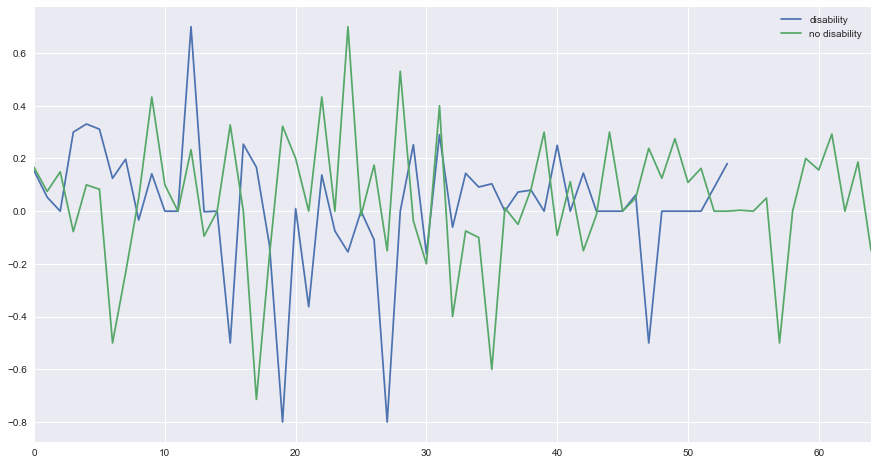

In [835]:
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0) # changing the default plot size to be bigger to facilitate reading

dis_obj_df = pd.DataFrame(dis_obj)
# dis_obj_df.head()

dis_sent_df = pd.DataFrame(dis_sent_only)
# dis_sent_df.head()

nodis_obj_df = pd.DataFrame(nodis_obj)
# mov_obj_df.head()

nodis_sent_df = pd.DataFrame(nodis_sent_only)
# mov_sent_df.head()

mylabels = ['disability', 'no disability']
a = dis_sent_df.plot()
nodis_sent_df.plot(ax=a)
print('Sentiment distributions compared:')
plt.legend(mylabels)
plt.show()

Objectivity of sentiment distributions compared:


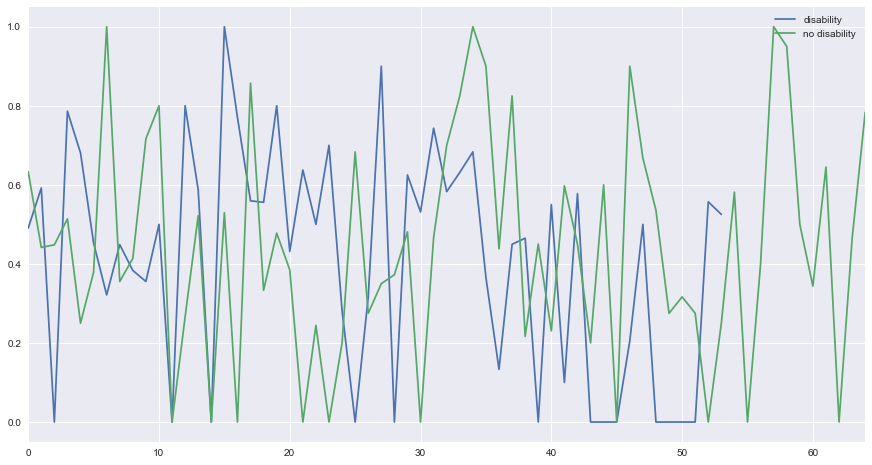

In [836]:
c = dis_obj_df.plot()
nodis_obj_df.plot(ax=c)
print('Objectivity of sentiment distributions compared:')
plt.legend(mylabels)
plt.show()

In [837]:
def headandtail(tuplelist, n):
    tuplelist.sort(reverse = True)
    print("TOP VALUES:")
    for i in range(n):
        print(tuplelist[i][1], tuplelist[i][0])
    
    print()
    print("BOTTOM VALUES:")
    lastindex = len(tuplelist) - 1
    for i in range(lastindex, lastindex - n, -1):
        print(tuplelist[i][1], tuplelist[i][0])

In [838]:
def logodds(countsA, countsB, word):
    ''' Straightforward.
    '''
    # using Laplacian smoothing to get better results
    odds = (countsA[word] + 1) / (countsB[word] + 1)
    
    return math.log(odds)

def signed_dunnings(countsA, totalA, countsB, totalB, word):
    ''' Less straightforward. This function calculates a signed (+1 / -1)
    version of Dunning's log likelihood. This number gets larger as the 
    frequency of the word in our two corpora diverges from its EXPECTED frequency
    i.e., the frequency it would have if it were equally distributed over both. 
    But it also tends to get larger as the raw frequency of the word increases.
    
    Note that this function requires two additional arguments:
    the total number of words in A and B. We could calculate that inside
    the function, but it's faster to calculate it just once, outside the function.
    
    Also note: the strict definition of Dunnings has no 'sign': it gets bigger
    whether a word is overrepresented in A or B. I've edited that so that Dunnings
    is positive if overrepresented in A, and negative if overrepresented in B.
    '''
    if word not in countsA and word not in countsB:
        return 0
    
    # the raw frequencies of this word in our two corpora
    # still doing a little Laplacian smoothing here
    a = countsA[word] + 0.1
    b = countsB[word] + 0.1
    
    # now let's calculate the expected number of times this
    # word would occur in both if the frequency were constant
    # across both
    overallfreq = (a + b) / (totalA + totalB)
    expectedA = totalA * overallfreq
    expectedB = totalB * overallfreq
    
    # and now the Dunning's formula
    dunning = 2 * ((a * math.log(a / expectedA)) + (b * math.log(b / expectedB)))
    
    if a < expectedA:
        return -dunning
    else:   
        return dunning

In [839]:
# ch = open('test.csv', 'r')
# # print(cdata)
# ch_df_two = pd.read_csv(ch, encoding='utf-8')

# del ch_df_two['Unnamed: 0']

# ch_df_two.head()

dis_word_list = []
dis_char_count = 0

undis_word_list = []
undis_char_count = 0

for i in char_basic.index:
    clss = char_basic['has_disability'][i]
    if clss == 'y':
        dis_char_count += 1
        dis_word_list.append(char_basic['words'])
    elif clss == 'n':
        undis_char_count += 1
        undis_word_list.append(char_basic['words'])
        
print('Dis lines:', dis_char_count)
print('Undis lines:', undis_char_count)
    

Dis lines: 54
Undis lines: 65


In [716]:
# ch = open('dis_df.csv', 'r')
# dis_df = pd.read_csv(ch, encoding='utf-8')

# del dis_df['Unnamed: 0']

print(dis_df.shape)
# dis_df = dis_df.reset_index(drop=True)
# dis_df.head()

# print(dis_df.shape)

# for i in dis_df.index:
#     dis = dis_df['has_disability'][i]
#     if dis == 0:
#         dis_df.drop(i, inplace=True)

# print(dis_df.shape)
# no_dis_sample = no_dis_ch_df.sample(n=54)
# ch_df_sample = ch_df_sample.reset_index(drop=True)


# dis_df.to_csv('dis_df.csv')

(54, 5)


In [718]:
# ch = open('no_dis_sample_5819.csv', 'r')
# no_dis_df = pd.read_csv(ch, encoding='utf-8')

# del no_dis_df['Unnamed: 0']

print(no_dis_df.shape)
# dis_df = dis_df.reset_index(drop=True)
# dis_df.head()

# print(dis_df.shape)

# for i in dis_df.index:
#     dis = dis_df['has_disability'][i]
#     if dis == 0:
#         dis_df.drop(i, inplace=True)

# print(dis_df.shape)
# no_dis_sample = no_dis_ch_df.sample(n=54)
# ch_df_sample = ch_df_sample.reset_index(drop=True)


# dis_df.to_csv('dis_df.csv')

(65, 5)


In [713]:
# ch = open('dis_df.csv', 'r')
# dis_df = pd.read_csv(ch, encoding='utf-8')

# print(ch_df_two.shape)

# for i in ch_df_two.index:
#     dis = ch_df_two['has_disability'][i]
#     if dis == 1:
#         ch_df_two.drop(i, inplace=True)

# print(ch_df_two.shape)
no_dis_sample = no_dis_ch_df.sample(n=60)
no_dis_sample = no_dis_sample.reset_index(drop=True)
# no_dis_sample.head()


#no_dis_sample.to_csv('nottodaypal.csv')
# no_dis_ch_df.head()

In [693]:
# dis_df_copy = dis_df

for i in dis_df.index:
    dis = dis_df_copy['has_disability'][i]
    words = dis_df_copy['words'][i]
    if len(words) < 150:
        print('found one')
        # dis_df_copy.drop(i, inplace=True)

In [857]:
# disab = Counter()
# no_disab = Counter()

dis_word_ct = 0
no_word_ct = 0

# num_rows = no_dis_df.shape[0]
# print('Total number of rows in no_dis_sample dataset = ', num_rows)
# dis_num = dis_df.shape[0]
# print('Total number of rows in dis_df_copy dataset = ', dis_num)

# Figure out how many rows are in youur DataFrame and put that number 
#  in a variable like 'numrows.' Then iterate through the 'text' column of the data frame.

for i in no_dis_df.index:
    words = tokenize(no_dis_df['words'][i])
    no_word_ct += len(words)
    
for i in dis_df.index:
    words = tokenize(dis_df['words'][i])
    dis_word_ct += len(words)

# disab_ct = len(disab)
# no_disab_ct = len(no_disab)

print('Total words describing with characters with disabilities = ', dis_word_ct)
print('Total words describing with characters without disabilities ', no_word_ct)

Total words describing with characters with disabilities =  7079
Total words describing with characters without disabilities  5819


In [841]:
# df_list = [no_dis_df, dis_df]

# no_dis_df_basic


# dis_df_basic

# char_df = pd.concat([no_dis_df, dis_df])
# char_df = char_df.reset_index(drop=True)
# char_df[61:91]

In [846]:
# Now, it's time to see the words most prevalent in each set of reviews.

# remember, the create_vocab function takes two parameters: a corpus of text and 'n' which represents
#  the max size of the created vocab. I'm going to make this number very high, but it can be adjusted
#  based on if our results are interesting or not.

dis_vocab = create_vocab(char_basic['words'], 15000)
print('Total vocab = ', len(dis_vocab))

# a list of common stop words to use for removing frequent words that are unenlightening:
stopwords = {'a', 'an', 'are', 'and', 'but', 'or', 'that', 'this', 'so', 
             'all', 'at', 'if', 'in', 'i', 'is', 'was', 'by', 'of', 'to', 
             'the', 'be', 'were'}

# Removing stopwords for more enlightening results
dis_vocab_nostop = list(set(dis_vocab) - stopwords)
print('Total vocab minus stop words = ', len(dis_vocab_nostop))

Total vocab =  4175
Total vocab minus stop words =  4168


In [847]:
disability = Counter()
no_disability = Counter()

num_rows = char_basic.shape[0]
print('Total number of rows in char_basic dataset = ', num_rows)

# Figure out how many rows are in youur DataFrame and put that number 
#  in a variable like 'numrows.' Then iterate through the 'text' column of the data frame.

for i in range(num_rows):
    counts = tokenize(char_basic['words'][i])
    if 'n' in char_basic['has_disability'][i]:
        addcounters(counts, no_disability)
    elif 'y' in char_basic['has_disability'][i]:
        addcounters(counts, disability)

dis_ct = len(disability)
no_dis_ct = len(no_disability)

print('Total words describing with characters with disabilities = ', dis_ct)
print('Total words describing with characters without disabilities ', no_dis_ct)

Total number of rows in char_basic dataset =  119
Total words describing with characters with disabilities =  2999
Total words describing with characters without disabilities  2419


### Explanation for above:
- Disability-character centric books due to discovery method, typically means more words for main characters
- Characters without disabilities had a lower average number of words per character (not surprising, given the above)

In [856]:
total_words = Counter()
addcounters(disability, total_words)
addcounters(no_disability, total_words)

# Create an empty list to hold pairs of (overrepresentation_measure, word) Then iterate through your 
# vocabulary. For each word, measure overrepresentation using either logodds or signed_dunnings.

overrep_words_log = []
overrep_words_dunnings = []

for wrd in dis_vocab_nostop:
    x = signed_dunnings(no_disability, no_dis_ct, disability, dis_ct, wrd)
    overrep_words_dunnings.append((x, wrd))

for word in dis_vocab_nostop:
    x = logodds(no_disability, disability, word)
    overrep_words_log.append((x, word))

# Finally use the headandtail function to display the top 25 and bottom 25 words in your tuplelist.

print('FOR LOG ODDS:')
headandtail(overrep_words_log, 50)
print('\n')
print('FOR DUNNINGS:')
headandtail(overrep_words_dunnings, 50)

FOR LOG ODDS:
TOP VALUES:
mustache 2.5649493574615367
bargain 2.5649493574615367
dad 2.4849066497880004
tie 2.0794415416798357
responded 2.0794415416798357
girlfriend 2.0794415416798357
beard 2.0794415416798357
spectacles 1.9459101490553132
rasped 1.9459101490553132
faced 1.9459101490553132
woman 1.791759469228055
wearing 1.791759469228055
thrust 1.791759469228055
thief 1.791759469228055
tent 1.791759469228055
sight 1.791759469228055
recoiled 1.791759469228055
nightshirt 1.791759469228055
hungry 1.791759469228055
drawing-room 1.791759469228055
bones 1.791759469228055
apron 1.791759469228055
abandoned 1.791759469228055
boots 1.7047480922384253
yanked 1.6094379124341003
welcomed 1.6094379124341003
snored 1.6094379124341003
slowed 1.6094379124341003
silenced 1.6094379124341003
sense 1.6094379124341003
save 1.6094379124341003
robe 1.6094379124341003
remained 1.6094379124341003
relief 1.6094379124341003
purse 1.6094379124341003
mount 1.6094379124341003
join 1.6094379124341003
intrigued 1.60